<a href="https://colab.research.google.com/github/nattzza/Credit-Card-Customer-Segmenation/blob/main/ML_Day_9_Credit_Card_Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### You are given a dataset of credit card transactions. The dataset contains 8500 customers and their activity over a 6-month period. Each transaction is characterized by 18 features described below.

### Your task is to find the most useful customer segmentation to improve the marketing campaigns of the company.

**The features:**

customer_id : id of the credit card holder

balance_account : balance amount left in the account to make purchases at the end of the 6-month period

purchases_amount : amount of purchases made from account

paid_advance : number of transactions made with “Cash in Advance” method

full_purchases : maximum purchase amount done in full payment

balance_frequency_update : how frequently the balance has been updated, score between 0 and 1 (1 = frequently - updated, 0 = not frequently updated)

installments : amount of purchases done in installments

purchases_frequency : how frequently the purchases are being made, score between 0 and 1 (1 = frequently - - purchased, 0 = not frequently purchased)

full_purchases_frequency : how frequently purchases are happening in full payment (1 = frequently purchased, - 0 = not frequently purchased)

purchases_installments_frequency : how frequently purchases in installments are being done (1 = frequently - done, 0 = not frequently done)

cash_advance_frequency : how frequently the cash in advance being paid

nr_cash_advances : cash in advance given by the user

nr_purchases : number of purchase transactions made

credit_limit : limit of credit card for user

fixed_rate_period : duration of fixed interest rate of credit card service for user (in months)

payments : amount of payment done by user

min_payments : minimum amount of payments made by user

full_payment_prc : percent of full payment paid by user

## 1. Getting and Loading the Dataset

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:

%matplotlib inline

# ----------------------------------GENERAL---------------------------------

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# ----------------------------------VISUALIZATION---------------------------

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# ----------------------------------PRE-PROCESSING---------------------------

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_samples, silhouette_score

# ----------------------------------PIPELINE AND MODELS----------------------

from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

### Define Distribution Plots Function

In [18]:
# DESCRIPTION --> # it plots the distributions of your data
def plot_distrib(df, ncols, nrows, figsize):
    vars_ = df.columns
    c = 0
    plt.figure(figsize=figsize)
    for v in vars_:
        ax = plt.subplot(nrows, ncols, c + 1)
        _, nbins, _ = plt.hist(df[v], 20, color="g", alpha=0.6, label=v)
        plt.xlabel(v)
        plt.legend(loc="best")
        c = c + 1
    plt.show()
    
# How to call this function? --> plot_distrib (target_df, number_of_cols, number_of_rows, figsize)

## 2. Exploratory Data Analysis

In [31]:
df = pd.read_csv("./card_transactions.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   customer_id                       8500 non-null   object 
 1   balance_account                   8500 non-null   float64
 2   purchases_amount                  8500 non-null   float64
 3   paid_advance                      8500 non-null   float64
 4   full_purchases                    8500 non-null   float64
 5   balance_frequency_update          8500 non-null   float64
 6   installments                      8500 non-null   float64
 7   purchases_frequency               8500 non-null   float64
 8   full_purchases_frequency          8500 non-null   float64
 9   purchases_installments_frequency  8500 non-null   float64
 10  cash_advance_frequency            8500 non-null   float64
 11  nr_cash_advances                  8500 non-null   int64  
 12  nr_pur

In [32]:
df.head()

,customer_id,balance_account,purchases_amount,paid_advance,full_purchases,balance_frequency_update,installments,purchases_frequency,full_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,nr_cash_advances,nr_purchases,credit_limit,fixed_rate_period,payments,min_payments,full_payment_prc
0,tGEg8fT2eCgVxdwS,9.298409,107.60,0.000000,0.00,0.909091,107.6,0.909091,0.000000,0.818182,0.000000,0,10,1000.0,11,89.868853,89.711672,0.428571
1,stEDu20sSKOXomjg,52.666422,150.30,0.000000,0.00,1.000000,150.3,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,6,54.722514,82.955180,0.000000
2,CEB2blrN3b88GsRe,1360.795674,0.00,462.861443,0.00,1.000000,0.0,0.000000,0.000000,0.000000,0.272727,6,0,1500.0,11,303.031979,443.781316,0.000000
3,0N0eBl8ySaZThxKE,2021.641161,363.18,0.000000,363.18,1.000000,0.0,1.000000,1.000000,0.000000,0.000000,0,13,2000.0,12,704.240770,795.859808,0.000000
4,6NLauoHUwtwOv4Wy,22.322374,95.00,1162.045833,95.00,0.363636,0.0,0.083333,0.083333,0.000000,0.166667,3,1,2500.0,12,4094.261427,40.142262,0.000000


In [26]:
# Checking if any id is duplicated along the df:

check_duplicated_ids = (df["customer_id"].value_counts() > 1).any()
size_of_duplicated_ids = (df["customer_id"].value_counts() > 1).sum()
print("Do we have duplicated customer id's within our df?: ", check_duplicated_ids)
print('\nHow many then?:\t', size_of_duplicated_ids if check_duplicated_ids==True else "None")

Do we have duplicated customer id's within our df?:  False

How many then?:	 None


In [33]:
df.head()

,customer_id,balance_account,purchases_amount,paid_advance,full_purchases,balance_frequency_update,installments,purchases_frequency,full_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,nr_cash_advances,nr_purchases,credit_limit,fixed_rate_period,payments,min_payments,full_payment_prc
0,tGEg8fT2eCgVxdwS,9.298409,107.60,0.000000,0.00,0.909091,107.6,0.909091,0.000000,0.818182,0.000000,0,10,1000.0,11,89.868853,89.711672,0.428571
1,stEDu20sSKOXomjg,52.666422,150.30,0.000000,0.00,1.000000,150.3,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,6,54.722514,82.955180,0.000000
2,CEB2blrN3b88GsRe,1360.795674,0.00,462.861443,0.00,1.000000,0.0,0.000000,0.000000,0.000000,0.272727,6,0,1500.0,11,303.031979,443.781316,0.000000
3,0N0eBl8ySaZThxKE,2021.641161,363.18,0.000000,363.18,1.000000,0.0,1.000000,1.000000,0.000000,0.000000,0,13,2000.0,12,704.240770,795.859808,0.000000
4,6NLauoHUwtwOv4Wy,22.322374,95.00,1162.045833,95.00,0.363636,0.0,0.083333,0.083333,0.000000,0.166667,3,1,2500.0,12,4094.261427,40.142262,0.000000


In [29]:
# If the power of debt payments are exluced in this analyses (if we care only to activate/promote spending of customers), the below columns could be deleted. 

df = df.drop(columns="full_payment_prc")        # percent of full payment paid by user
df = df.drop(columns="min_payments")            # minimum amount of payments made by user
df = df.drop(columns="payments")                 # amount of payment done by user
df = df.drop(columns="fixed_rate_period")       # duration of fixed interest rate of credit card service for user (in months)
df = df.drop(columns="nr_cash_advances")        # cash in advance given by the user
df = df.drop(columns="cash_advance_frequency")  #  how frequently the cash in advance being paid

In [34]:
df.head()

,customer_id,balance_account,purchases_amount,paid_advance,full_purchases,balance_frequency_update,installments,purchases_frequency,full_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,nr_cash_advances,nr_purchases,credit_limit,fixed_rate_period,payments,min_payments,full_payment_prc
0,tGEg8fT2eCgVxdwS,9.298409,107.60,0.000000,0.00,0.909091,107.6,0.909091,0.000000,0.818182,0.000000,0,10,1000.0,11,89.868853,89.711672,0.428571
1,stEDu20sSKOXomjg,52.666422,150.30,0.000000,0.00,1.000000,150.3,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,6,54.722514,82.955180,0.000000
2,CEB2blrN3b88GsRe,1360.795674,0.00,462.861443,0.00,1.000000,0.0,0.000000,0.000000,0.000000,0.272727,6,0,1500.0,11,303.031979,443.781316,0.000000
3,0N0eBl8ySaZThxKE,2021.641161,363.18,0.000000,363.18,1.000000,0.0,1.000000,1.000000,0.000000,0.000000,0,13,2000.0,12,704.240770,795.859808,0.000000
4,6NLauoHUwtwOv4Wy,22.322374,95.00,1162.045833,95.00,0.363636,0.0,0.083333,0.083333,0.000000,0.166667,3,1,2500.0,12,4094.261427,40.142262,0.000000


Visualize Sales vs. Order Date

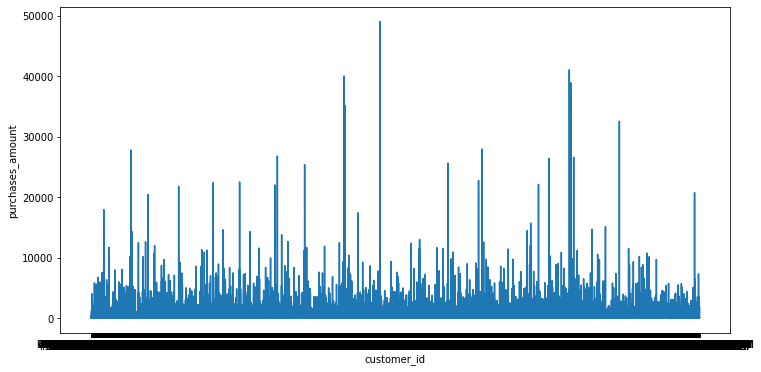

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
# sns.lineplot(x=df['customer_id'], y=df['purchases_amount']);
sns.lineplot(x=df['customer_id'], y=df['purchases_amount']);

In [36]:
df['purchases_amount'].describe()

count     8500.000000
mean       999.561312
std       2154.189460
min          0.000000
25%         39.000000
50%        360.000000
75%       1105.897500
max      49039.570000
Name: purchases_amount, dtype: float64

In [10]:
# Checking our colum values data types (str, int, float, bool):

print('\nDo we have **strings** inside of our df?:\t', (df.dtypes == "object").any(), '\n')
print('\nDo we have **integers** inside of our df?:\t', (df.dtypes == "int").any(), '\n')
print('\nDo we have **floats** inside of our df?:\t', (df.dtypes == "float64").any(), '\n')
print('\nDo we have **boolean** inside of our df?:\t', (df.dtypes == "bool").any(), '\n')


Do we have **strings** inside of our df?:	 True 


Do we have **integers** inside of our df?:	 True 


Do we have **floats** inside of our df?:	 True 


Do we have **boolean** inside of our df?:	 False 



### 2.1 Data Vistualization

### Visualization of the data: Correlation Heatmap

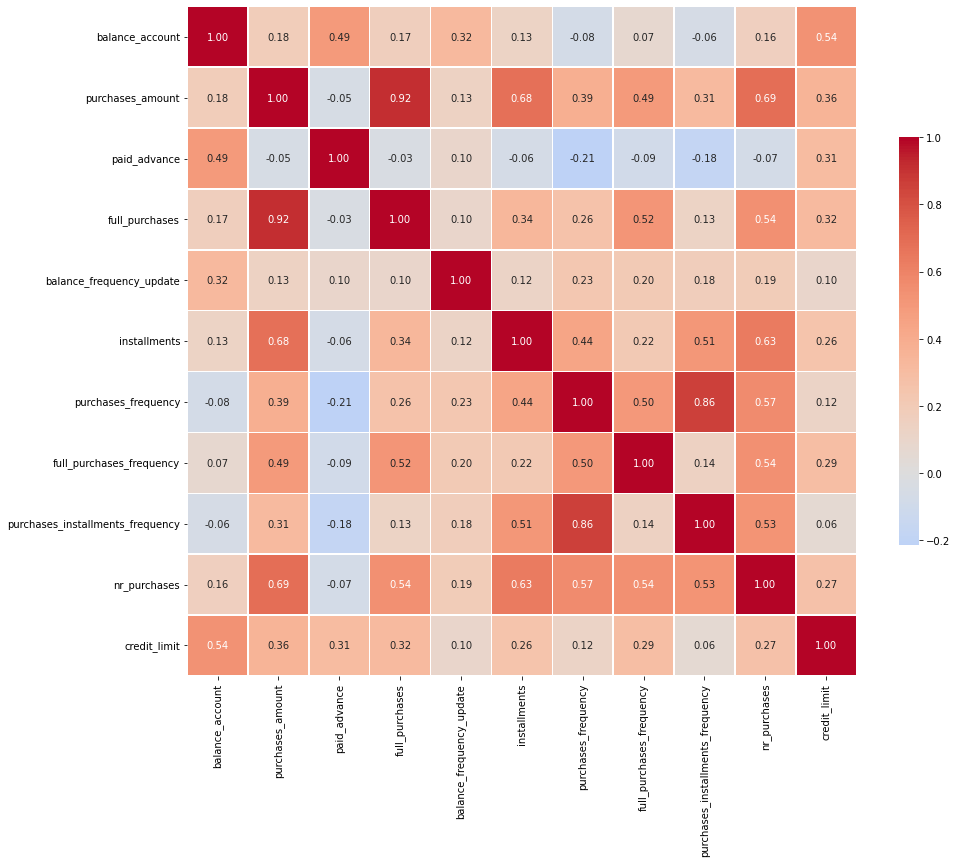

In [17]:
corr = df.corr() # computing correlation values
fig, ax = plt.subplots(figsize=(15, 15)) # setting up the empty plot to use next

# Assembly of the heatmap:
h = sns.heatmap(
    corr,
    cmap="coolwarm",
    vmax=1,
    fmt=".2f",
    annot=True,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)

#### Dropping Customer ID out for further processing

In [38]:
df = df.drop(columns="customer_id")


In [39]:
df.head()

,balance_account,purchases_amount,paid_advance,full_purchases,balance_frequency_update,installments,purchases_frequency,full_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,nr_cash_advances,nr_purchases,credit_limit,fixed_rate_period,payments,min_payments,full_payment_prc
0,9.298409,107.60,0.000000,0.00,0.909091,107.6,0.909091,0.000000,0.818182,0.000000,0,10,1000.0,11,89.868853,89.711672,0.428571
1,52.666422,150.30,0.000000,0.00,1.000000,150.3,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,6,54.722514,82.955180,0.000000
2,1360.795674,0.00,462.861443,0.00,1.000000,0.0,0.000000,0.000000,0.000000,0.272727,6,0,1500.0,11,303.031979,443.781316,0.000000
3,2021.641161,363.18,0.000000,363.18,1.000000,0.0,1.000000,1.000000,0.000000,0.000000,0,13,2000.0,12,704.240770,795.859808,0.000000
4,22.322374,95.00,1162.045833,95.00,0.363636,0.0,0.083333,0.083333,0.000000,0.166667,3,1,2500.0,12,4094.261427,40.142262,0.000000


### Visualization of the data: Histograms

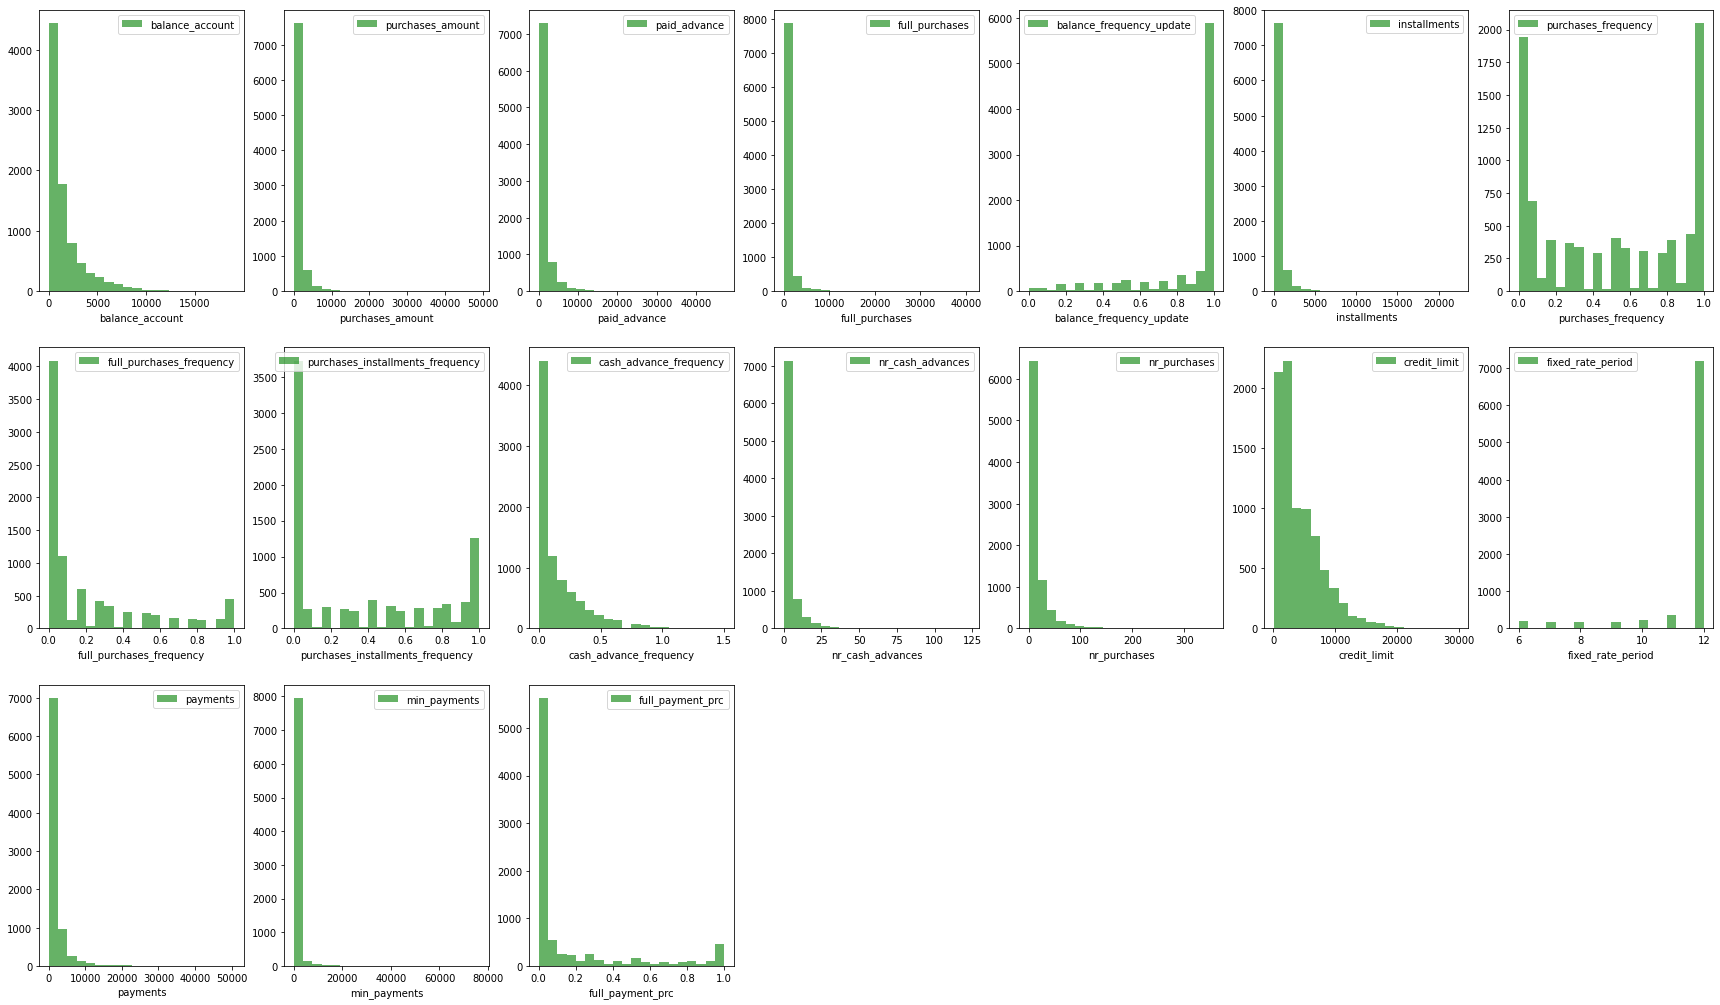

In [40]:
plot_distrib(df, ncols=7, nrows=5, figsize=(30, 30)) 
# calling the function we defined at the beginning of this notebook

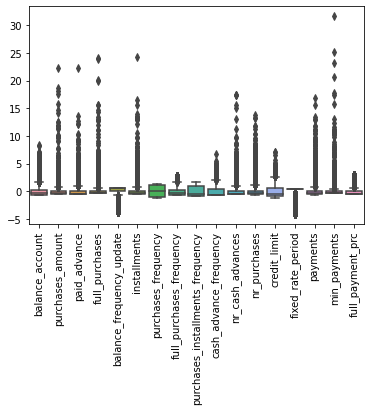

<Figure size 1080x1080 with 0 Axes>

In [49]:
scaler = StandardScaler() # Scaling the data so the plot makes sense once it is ploted
data_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
ax = sns.boxplot(data=data_scaled)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.figure(figsize=(15,15))
plt.show()

### Data interpreation from the histogram and box plot

#### Feature meaning: 
purchases_frequency : how frequently the purchases are being made, score between 0 and 1 (1 = frequently - - purchased, 0 = not frequently purchased)

**Purchases Frequency** There are hardly outliers shown in the box plot. This suggests that majorities of credit card holders do make the most frequent and another majority group hardly purchase anything. 

